# # ESD Data Analysis Notebook
# **Objective**: Evaluate market opportunities for parts with and without discounts in Vertical A, focusing on factors such as industry, customers, sales, and market potential.  
# **Author**: Monish  
# **Date**: June 26, 2025  

## This notebook performs exploratory data analysis (EDA) on Sheet 1 of the ESD dataset, followed by targeted analysis to address the objective. The code is structured to demonstrate proficiency in data science, including data cleaning, visualization, statistical testing, and customer segmentation.

## ## Step 0: Import Libraries


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import ttest_ind, kruskal

# Set visualization style for consistency
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## ## Step 1: Data Loading and Initial Inspection


In [2]:
# Load data from Excel (only Sheet 1 is needed for the objective)
file_path ='ESD Data Analysis.xlsx'
sheet1 =  pd.read_excel(file_path, sheet_name='Sheet 1')


sheet1.head()



,Parent Customer Number,Customer Sub-Vertical,Industry,Second Level Dealer?,Fleet Size,Covered at Parent Level,Parent in CAT?,Discount - Parent,Market Potential (USD),Sales (USD)
0,1,Vertical A,Industry G,No,20+ Units,Yes,Yes,0.00,552053.000000,189248.484040
1,2,Vertical A,Industry W,No,20+ Units,Yes,Yes,0.00,482917.502141,143925.676649
2,3,Vertical A,Industry G,No,20+ Units,Yes,Yes,0.06,422414.992048,84088.635400
3,4,Vertical A,Industry G,No,Managed,Yes,Yes,0.00,394918.069432,72290.821680
4,5,Vertical A,Industry G,No,20+ Units,Yes,Yes,0.09,625669.235369,315636.963180


In [3]:
# Basic descriptive statistics
print("Descriptive Statistics:")
print(sheet1.describe())

# Check for missing values
print("\nMissing Values:")
print(sheet1.isnull().sum())

# Check data types
print("\nData Types:")
print(sheet1.dtypes)

# Inspect numerical column ranges
numerical_cols = ['Sales (USD)', 'Market Potential (USD)', 'Discount - Parent']
print("\nNumerical Column Ranges:")
for col in numerical_cols:
    print(f"{col}: Min = {sheet1[col].min()}, Max = {sheet1[col].max()}")

# Display unique values for categorical columns
categorical_cols = ['Industry', 'Customer Sub-Vertical', 'Fleet Size']
print("\nUnique Values:")
for col in categorical_cols:
    unique_values = sheet1[col].unique()
    print(f"Column '{col}' has {len(unique_values)} unique values: {unique_values}")

Descriptive Statistics:
       Parent Customer Number  Discount - Parent  Market Potential (USD)  \
count             3576.000000        3576.000000             3576.000000   
mean              1788.500000           0.003248             5837.921407   
std               1032.446609           0.012540            36545.674728   
min                  1.000000           0.000000                0.000000   
25%                894.750000           0.000000                0.000000   
50%               1788.500000           0.000000              124.595874   
75%               2682.250000           0.000000              760.815276   
max               3576.000000           0.142500           999246.005631   

         Sales (USD)  
count    3576.000000  
mean     3837.773276  
std     34221.616812  
min      -484.699600  
25%         0.000000  
50%        18.747190  
75%       233.301145  
max    999621.659960  

Missing Values:
Parent Customer Number     0
Customer Sub-Vertical      0
Industry 

### **Observations**:
 - The dataset contains numerical columns (`Sales (USD)`, `Market Potential (USD)`, `Discount - Parent`) and categorical columns (`Industry`, `Customer Sub-Vertical`, `Fleet Size`).
 - Negative sales values and zero market potential values need attention during cleaning.
- No missing values observed .

## ## Step 2: Data Cleaning

In [4]:
clean_sheet1 = sheet1.copy()

# Remove negative sales (invalid for analysis)
neg_sales = (clean_sheet1['Sales (USD)'] < 0).sum()
clean_sheet1 = clean_sheet1[clean_sheet1['Sales (USD)'] >= 0]
print(f"Removed {neg_sales} rows with negative Sales (USD)")

# Impute zero Market Potential with Sales (assuming zero market potential is a data entry error)
zero_market = (clean_sheet1['Market Potential (USD)'] == 0).sum()
clean_sheet1.loc[clean_sheet1['Market Potential (USD)'] == 0, 'Market Potential (USD)'] = clean_sheet1['Sales (USD)']
print(f"Imputed {zero_market} zero Market Potential values with Sales (USD)")

# Round Discount - Parent to two decimal places for consistency
clean_sheet1['Discount - Parent'] = clean_sheet1['Discount - Parent'].round(2)
print(f"Unique Discount - Parent values after rounding: {len(clean_sheet1['Discount - Parent'].unique())}")

Removed 25 rows with negative Sales (USD)
Imputed 1290 zero Market Potential values with Sales (USD)
Unique Discount - Parent values after rounding: 13


### **Rationale**:
- Negative sales are removed as they are likely errors or returns, which could skew market opportunity analysis
- Zero market potential is imputed with sales to avoid potential.
- Rounding discounts ensures consistency in analysis.


## ## Step 3: Derived Metrics

In [5]:
# Calculate Lost Opportunity (clipped to avoid negative values)
clean_sheet1['Lost Opportunity'] = (clean_sheet1['Market Potential (USD)'] - clean_sheet1['Sales (USD)']).clip(lower=0)

# Calculate Market Share (handle division by zero)
clean_sheet1['Market Share'] = np.where(
    clean_sheet1['Market Potential (USD)'] > 0,
    clean_sheet1['Sales (USD)'] / clean_sheet1['Market Potential (USD)'],
    0
)

# Display first few rows with new metrics
clean_sheet1.head()

,Parent Customer Number,Customer Sub-Vertical,Industry,Second Level Dealer?,Fleet Size,Covered at Parent Level,Parent in CAT?,Discount - Parent,Market Potential (USD),Sales (USD),Lost Opportunity,Market Share
0,1,Vertical A,Industry G,No,20+ Units,Yes,Yes,0.00,552053.000000,189248.484040,362804.515960,0.342809
1,2,Vertical A,Industry W,No,20+ Units,Yes,Yes,0.00,482917.502141,143925.676649,338991.825492,0.298034
2,3,Vertical A,Industry G,No,20+ Units,Yes,Yes,0.06,422414.992048,84088.635400,338326.356648,0.199066
3,4,Vertical A,Industry G,No,Managed,Yes,Yes,0.00,394918.069432,72290.821680,322627.247752,0.183053
4,5,Vertical A,Industry G,No,20+ Units,Yes,Yes,0.09,625669.235369,315636.963180,310032.272189,0.504479


### **Metrics Explained**:
- **Lost Opportunity**: Market Potential - Sales, representing untapped revenue.
- **Market Share**: Sales / Market Potential, indicating penetration in the market.

## ## Step 4: Exploratory Data Analysis (EDA)

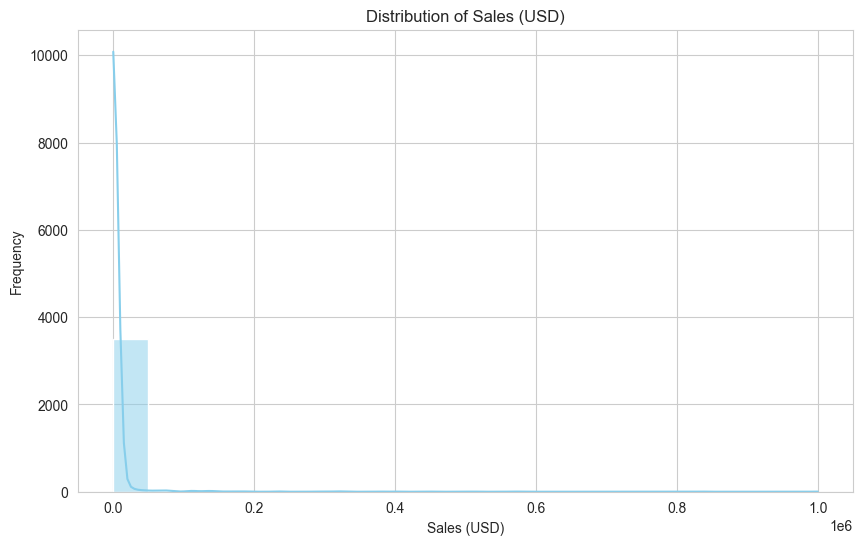

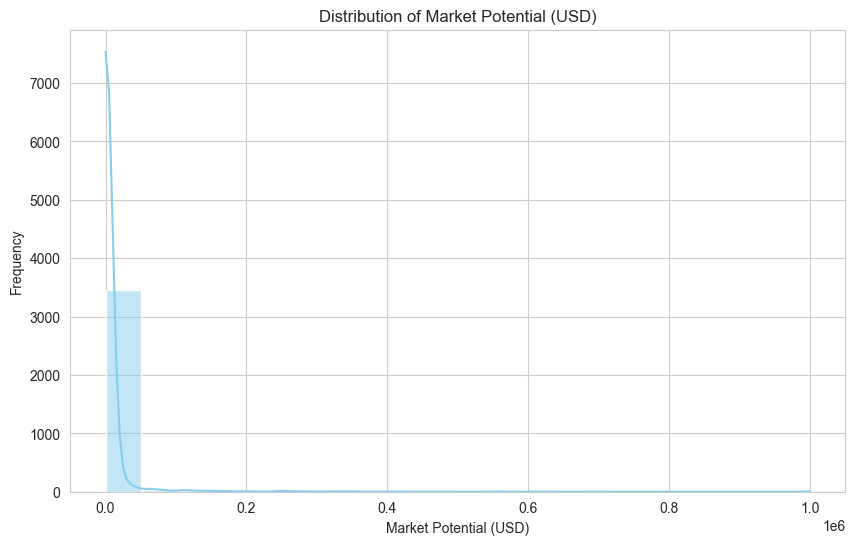

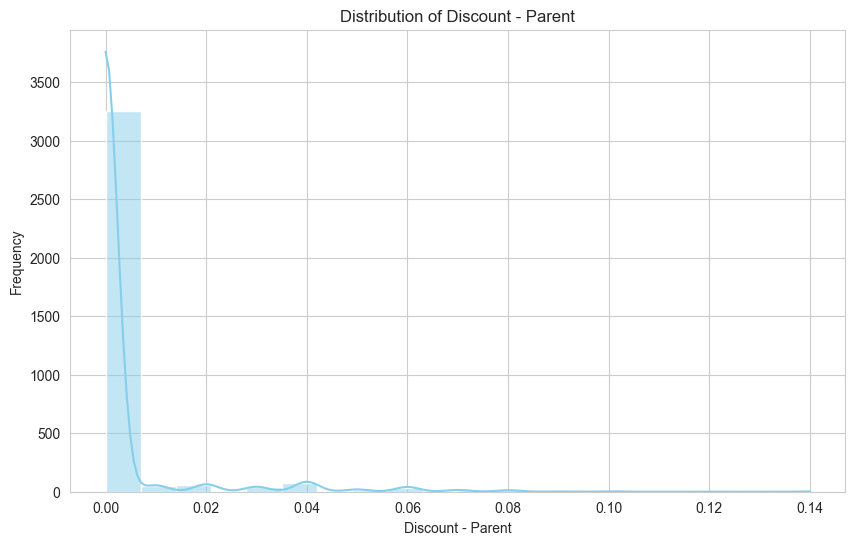

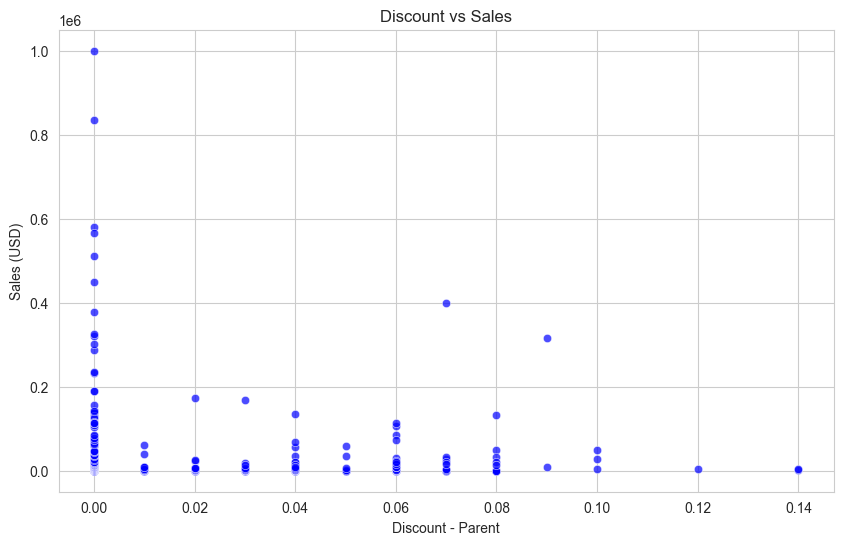

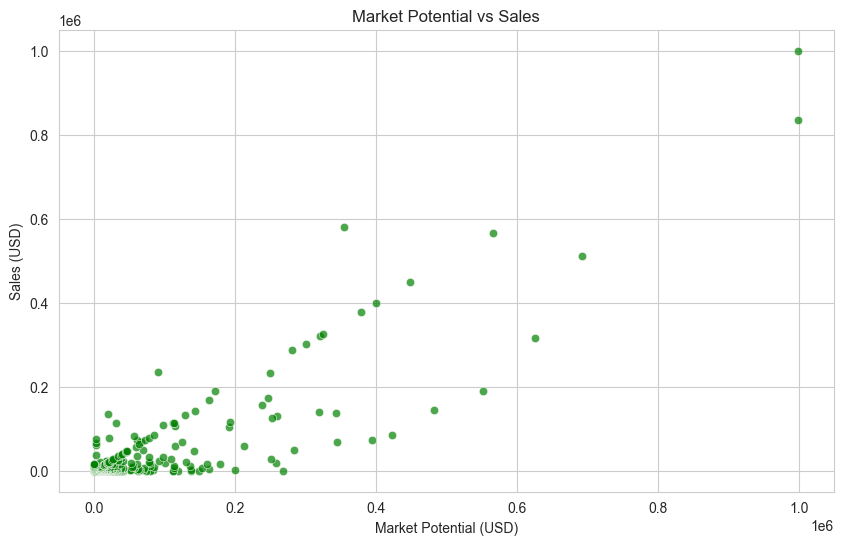

In [6]:
# Distribution of numerical columns
for col in numerical_cols:
    plt.figure()
    sns.histplot(clean_sheet1[col], kde=True, bins=20, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Scatter plot: Discount vs Sales
plt.figure()
sns.scatterplot(data=clean_sheet1, x='Discount - Parent', y='Sales (USD)', color='blue', alpha=0.7)
plt.title('Discount vs Sales')
plt.xlabel('Discount - Parent')
plt.ylabel('Sales (USD)')
plt.show()

# Scatter plot: Market Potential vs Sales
plt.figure()
sns.scatterplot(data=clean_sheet1, x='Market Potential (USD)', y='Sales (USD)', color='green', alpha=0.7)
plt.title('Market Potential vs Sales')
plt.xlabel('Market Potential (USD)')
plt.ylabel('Sales (USD)')
plt.show()


### **EDA Insights**:
- Distributions reveal the spread and skewness of key metrics (e.g., Sales and Market Potential may be right-skewed).
- Scatter plots help identify relationships, such as whether higher discounts correlate with higher sales.

## ## Step 5: Focus on Vertical A for Objective


Discount Status Summary for Vertical A:
             Sales (USD)               Market Potential (USD)                 \
                     sum          mean                    sum           mean   
Discounted                                                                     
False       7.847258e+06  33535.291538           1.319615e+07   56393.813228   
True        7.348054e+05  48987.024878           2.084491e+06  138966.071588   

           Lost Opportunity               Market Share Customer Count  
                        sum          mean         mean          count  
Discounted                                                             
False          5.928218e+06  25334.264428     1.161980            234  
True           1.356680e+06  90445.316831     0.536054             15  


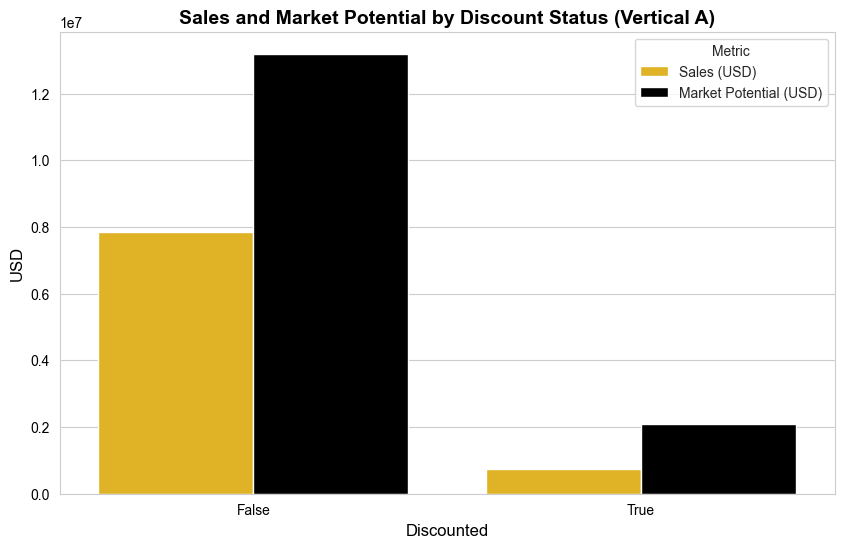

In [7]:
vertical_a = clean_sheet1[clean_sheet1['Customer Sub-Vertical'] == 'Vertical A'].copy()
vertical_a['Discounted'] = vertical_a['Discount - Parent'] > 0

# Group by discount status for key metrics
discount_summary = vertical_a.groupby('Discounted').agg({
    'Sales (USD)': ['sum', 'mean'],
    'Market Potential (USD)': ['sum', 'mean'],
    'Lost Opportunity': ['sum', 'mean'],
    'Market Share': 'mean',
    'Parent Customer Number': 'count'
}).rename(columns={'Parent Customer Number': 'Customer Count'})
print("Discount Status Summary for Vertical A:")
print(discount_summary)

# Define Caterpillar color scheme
cat_yellow = '#FFC107'
cat_black = '#000000'
cat_palette = [cat_yellow, cat_black]

# Visualize Sales and Market Potential by Discount Status
plt.figure()
discount_summary_plot = discount_summary[[('Sales (USD)', 'sum'), ('Market Potential (USD)', 'sum')]].reset_index()
discount_summary_plot.columns = ['Discounted', 'Sales (USD)', 'Market Potential (USD)']
discount_summary_melted = discount_summary_plot.melt(id_vars='Discounted', value_vars=['Sales (USD)', 'Market Potential (USD)'])
sns.barplot(data=discount_summary_melted, x='Discounted', y='value', hue='variable', palette=cat_palette)
plt.title('Sales and Market Potential by Discount Status (Vertical A)', color=cat_black, fontsize=14, weight='bold')
plt.ylabel('USD', color=cat_black, fontsize=12)
plt.xlabel('Discounted', color=cat_black, fontsize=12)
plt.legend(title='Metric', loc='upper right')
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')
plt.tick_params(axis='x', colors=cat_black)
plt.tick_params(axis='y', colors=cat_black)
plt.savefig('sales_market_potential_bar.png', dpi=300, bbox_inches='tight')
plt.show()

### **Insights**:
- Compare total and average Sales and Market Potential between discounted and non-discounted groups.
- Lost Opportunity and Market Share metrics highlight the effectiveness of discounts in capturing market potential.

## ## Step 6: Statistical Testing


In [8]:
# T-test for Sales (Discounted vs Non-Discounted)
non_discounted_sales = vertical_a[vertical_a['Discounted'] == False]['Sales (USD)']
discounted_sales = vertical_a[vertical_a['Discounted'] == True]['Sales (USD)']
t_stat, p_value = ttest_ind(non_discounted_sales, discounted_sales, equal_var=False)
print(f"T-test Sales (Non-Discounted vs Discounted): p-value = {p_value:.4f}")

# Kruskal-Wallis for Lost Opportunity by Discount Level
discount_levels = vertical_a['Discount - Parent'].unique()
groups = [vertical_a[vertical_a['Discount - Parent'] == d]['Lost Opportunity'] for d in discount_levels]
stat, p_value = kruskal(*groups)
print(f"Kruskal-Wallis Lost Opportunity by Discount Level: p-value = {p_value:.4f}")

T-test Sales (Non-Discounted vs Discounted): p-value = 0.5008
Kruskal-Wallis Lost Opportunity by Discount Level: p-value = 0.0138


### **Interpretation**:
- A low p-value (< 0.05) in the T-test suggests discounts significantly affect sales.
- Kruskal-Wallis tests whether different discount levels impact lost opportunity, accounting for non-normal distributions.

## ## Step 7: Segmentation Analysis by Fleet Size


Fleet Size and Discount Summary:
                        Sales (USD)  Lost Opportunity  Market Share  \
Fleet Size Discounted                                                 
1 Unit     False       1.405099e+05      1.956077e+05      1.733066   
           True        1.950102e+01      1.140587e+02      0.146010   
2-5 Units  False       8.110714e+04      5.025642e+05      0.631136   
           True        8.418855e+03      0.000000e+00      2.407252   
20+ Units  False       5.294575e+06      2.771575e+06      0.649113   
           True        4.576390e+05      9.644708e+05      0.359176   
6-19 Units False       1.115295e+06      9.706070e+05      1.262482   
           True        2.071366e+05      3.595363e+05      0.393846   
Managed    False       1.215771e+06      1.487863e+06      0.346538   
           True        6.159144e+04      3.255860e+04      0.681631   

                       Customer Count  
Fleet Size Discounted                  
1 Unit     False                  

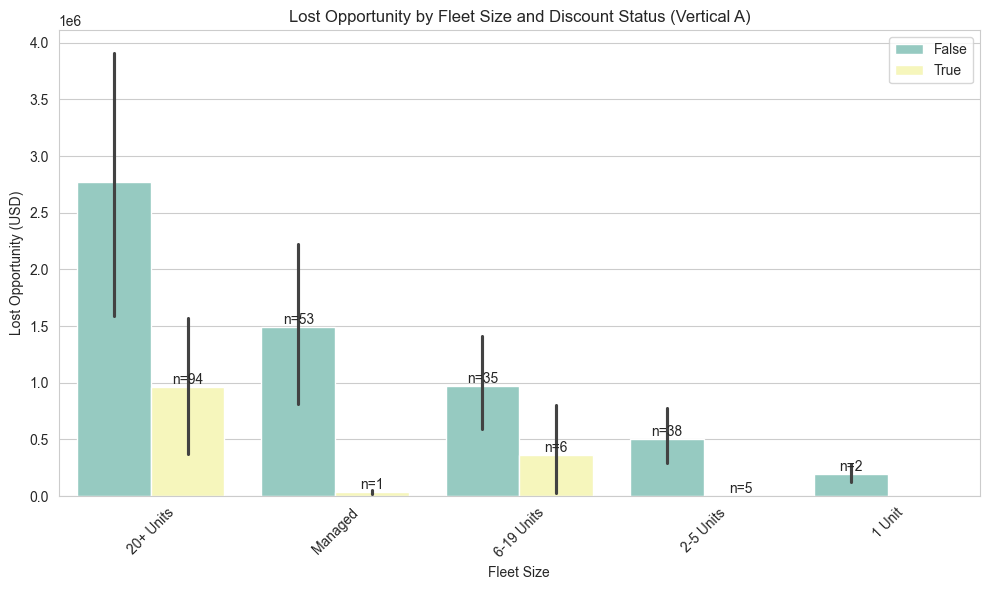

In [9]:
fleet_summary = vertical_a.groupby(['Fleet Size', 'Discounted']).agg({
    'Sales (USD)': 'sum',
    'Lost Opportunity': 'sum',
    'Market Share': 'mean',
    'Parent Customer Number': 'count'
}).rename(columns={'Parent Customer Number': 'Customer Count'})
print("Fleet Size and Discount Summary:")
print(fleet_summary)

# Visualize Lost Opportunity by Fleet Size and Discount Status
plt.figure()
bar_plot = sns.barplot(data=vertical_a, x='Fleet Size', y='Lost Opportunity', hue='Discounted', estimator=sum, palette='Set3')
for bar in bar_plot.patches:
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    for idx, row in fleet_summary.reset_index().iterrows():
        if bar.get_x() < (idx + 0.5) * bar.get_width() and bar.get_x() >= (idx - 0.5) * bar.get_width():
            count = row['Customer Count']
            plt.text(x, height, f"n={count}", ha='center', va='bottom')
            break
plt.title('Lost Opportunity by Fleet Size and Discount Status (Vertical A)')
plt.ylabel('Lost Opportunity (USD)')
plt.xlabel('Fleet Size')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### **Insights**:
- Fleet size may influence the effectiveness of discounts, with larger fleets potentially showing higher lost opportunities.
- Customer counts per group provide context for the scale of opportunities.

## ## Step 8: Customer Segmentation with Clustering

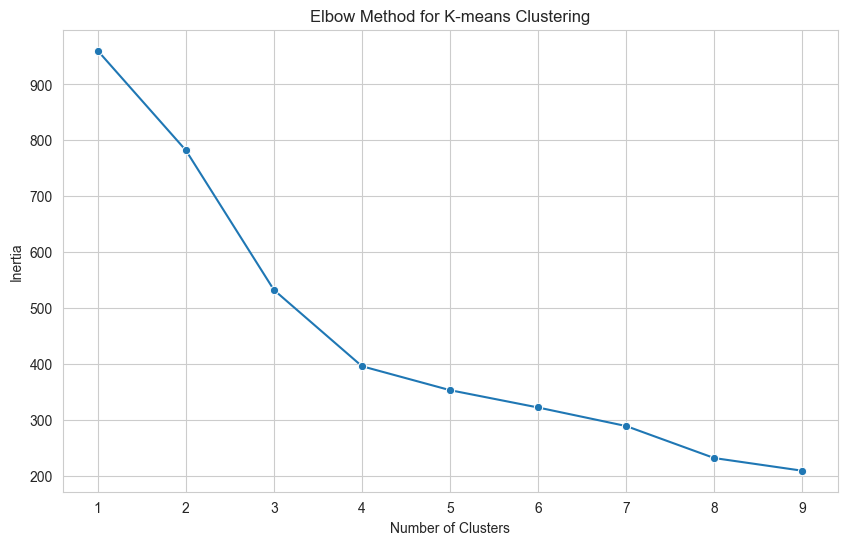

Cluster Summary for Vertical A:
           Sales (USD)  Lost Opportunity  Discount - Parent  Discounted  \
Cluster                                                                   
0         14517.065796      14313.365626           0.000446    0.022321   
1        645124.336643      57558.380044           0.000000    0.000000   
2         76815.517629     196492.286748           0.030000    0.526316   

         Customer Count  
Cluster                  
0                   224  
1                     6  
2                    19  


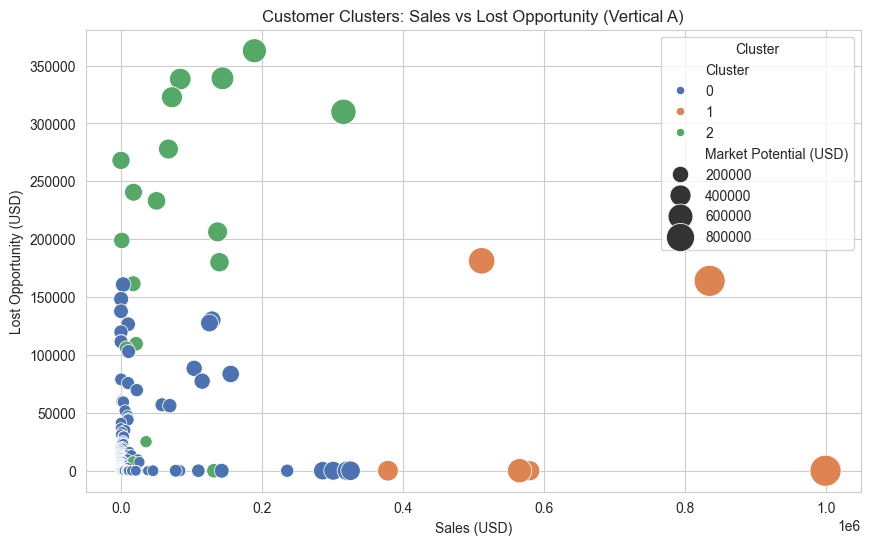

In [10]:
features = vertical_a[['Sales (USD)', 'Lost Opportunity', 'Discount - Parent', 'Fleet Size', 'Industry']]
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['Sales (USD)', 'Lost Opportunity', 'Discount - Parent']),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['Fleet Size', 'Industry'])
])
X_scaled = preprocessor.fit_transform(features)

# Elbow method to determine optimal clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
plt.figure()
sns.lineplot(x=range(1, 10), y=inertia, marker='o')
plt.title('Elbow Method for K-means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Fit K-means with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
vertical_a['Cluster'] = kmeans.fit_predict(X_scaled)

# Summarize clusters
print("Cluster Summary for Vertical A:")
print(vertical_a.groupby('Cluster').agg({
    'Sales (USD)': 'mean',
    'Lost Opportunity': 'mean',
    'Discount - Parent': 'mean',
    'Discounted': 'mean',
    'Parent Customer Number': 'count'
}).rename(columns={'Parent Customer Number': 'Customer Count'}))

# Visualize clusters
plt.figure()
sns.scatterplot(data=vertical_a, x='Sales (USD)', y='Lost Opportunity', hue='Cluster', palette='deep', size='Market Potential (USD)', sizes=(50, 500))
plt.title('Customer Clusters: Sales vs Lost Opportunity (Vertical A)')
plt.xlabel('Sales (USD)')
plt.ylabel('Lost Opportunity (USD)')
plt.legend(title='Cluster')
plt.show()

### **Insights**:
- Clusters reveal distinct customer segments (e.g., high sales/low lost opportunity, high discounts/high lost opportunity).
- Useful for targeting specific customer groups for discount strategies.

## ## Step 9: Pareto Analysis

Top 20% Customers by Lost Opportunity:
    Parent Customer Number  Lost Opportunity  Discounted  Cumulative
0                        1     362804.515960       False    0.049802
1                        2     338991.825492       False    0.096336
2                        3     338326.356648        True    0.142778
3                        4     322627.247752       False    0.187065
4                        5     310032.272189        True    0.229623
5                        6     277907.965360       False    0.267772
6                        7     268081.708803       False    0.304571
7                        8     240578.279141       False    0.337596
8                        9     233119.212336        True    0.369596
10                      11     206349.305736       False    0.397922
11                      12     198914.951825       False    0.425227
12                      13     181328.713866       False    0.450118
13                      14     180111.807739       False    0.47

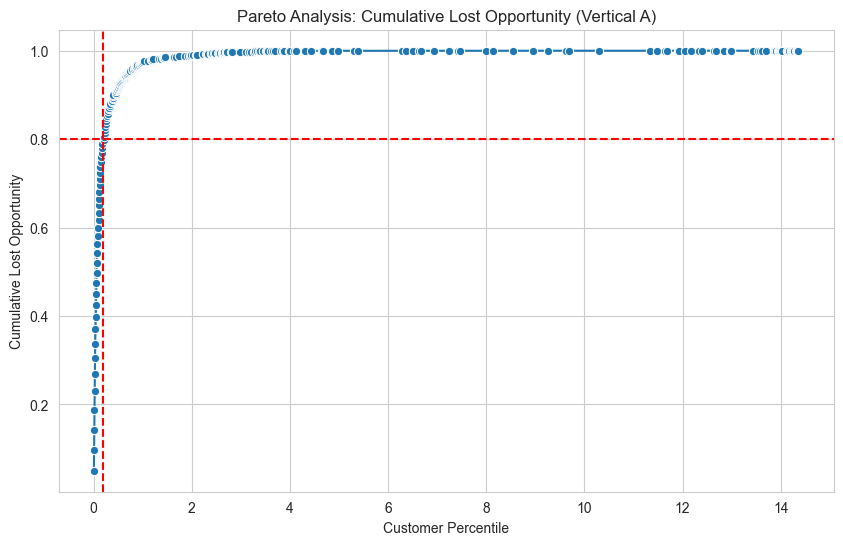

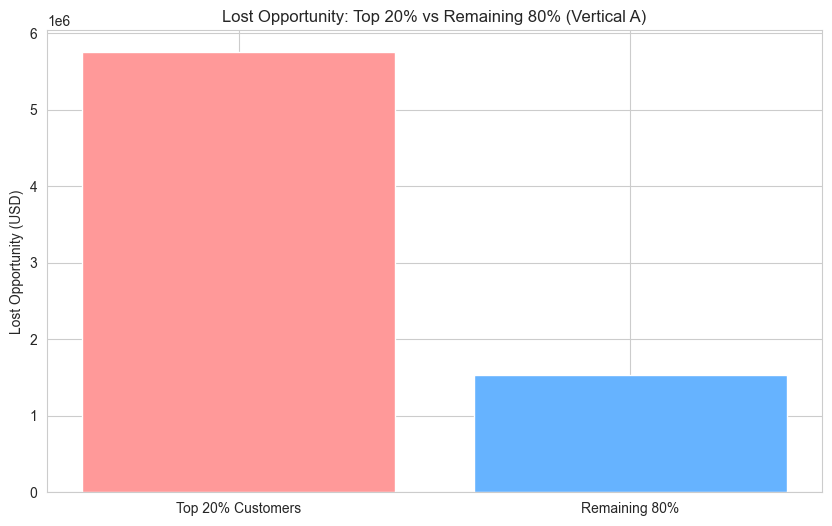

In [11]:
pareto_data = vertical_a[['Parent Customer Number', 'Lost Opportunity', 'Discounted']].sort_values('Lost Opportunity', ascending=False)
pareto_data['Cumulative'] = pareto_data['Lost Opportunity'].cumsum() / pareto_data['Lost Opportunity'].sum()
pareto_data['Customer Percentile'] = (pareto_data.index + 1) / len(pareto_data)
top_20_percent = pareto_data[pareto_data['Customer Percentile'] <= 0.2]
print("Top 20% Customers by Lost Opportunity:")
print(top_20_percent[['Parent Customer Number', 'Lost Opportunity', 'Discounted', 'Cumulative']])

# Pareto curve
plt.figure()
sns.lineplot(data=pareto_data, x='Customer Percentile', y='Cumulative', marker='o')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.axvline(x=0.2, color='r', linestyle='--')
plt.title('Pareto Analysis: Cumulative Lost Opportunity (Vertical A)')
plt.xlabel('Customer Percentile')
plt.ylabel('Cumulative Lost Opportunity')
plt.show()

# Simple Pareto summary
plt.figure()
plt.bar(['Top 20% Customers', 'Remaining 80%'], 
        [top_20_percent['Lost Opportunity'].sum(), pareto_data['Lost Opportunity'].sum() - top_20_percent['Lost Opportunity'].sum()],
        color=['#ff9999', '#66b3ff'])
plt.title('Lost Opportunity: Top 20% vs Remaining 80% (Vertical A)')
plt.ylabel('Lost Opportunity (USD)')
plt.show()

# **Insights**:
- The Pareto principle (80/20 rule) likely applies, with a small percentage of customers driving most lost opportunities.
- Discount status of top customers can guide targeted discount strategies.